# ts2g using quantile strategy

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from core import model 
from timeseries.quantiles import TimeseriesToQuantileGraph
# from timeseries.strategies import TimeseriesToGraphStrategy

## Loading data 

We first load the dataset :)

In [3]:
amazon_data = pd.read_csv(os.path.join(os.getcwd(), "amazon", "AMZN.csv"))   

To properly use the ‘Date’ column, we convert it to datetime format and ensure the dates are recognized as date objects. We then set the ‘Date’ column as the index of the DataFrame. This creates a time-series structure, facilitating analysis and visualization over time.

In [4]:
amazon_data["Date"] = pd.to_datetime(amazon_data["Date"])
amazon_data.set_index("Date", inplace=True)

# How does the time series look like?

In [5]:
def plot_timeseries(sequence, title, x_legend, y_legend, color):
    plt.figure(figsize=(10, 6))
    plt.plot(sequence, linestyle='-', color=color)
    
    plt.title(title)
    plt.xlabel(x_legend)
    plt.ylabel(y_legend)
    plt.grid(True)
    plt.show()

In [6]:
def plot_timeseries_sequence(df_column, title, x_legend, y_legend, color='black'):
    sequence = model.Timeseries(model.TimeseriesArrayStream(df_column)).to_sequence()
    plot_timeseries(sequence, title, x_legend, y_legend, color)

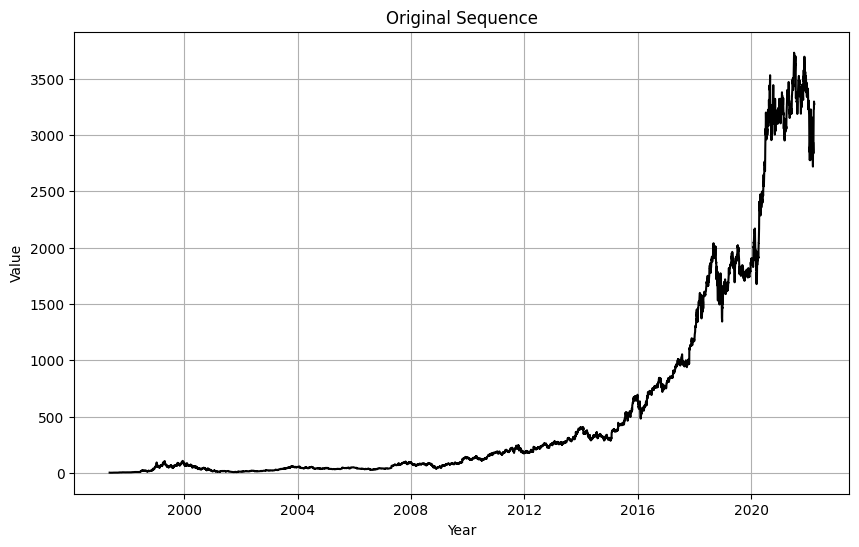

In [7]:
plot_timeseries_sequence(amazon_data["Close"], "Original Sequence", "Year", "Value")

Given the great length of the timeseries, let's focus on some sub-segments, so that we can better appreciate its behavior.

In [8]:
segment_1 = amazon_data[60:120]
segment_2 = amazon_data[4000:4060]
segment_3 = amazon_data[6000:6060]

How do the plots for these segments look like?

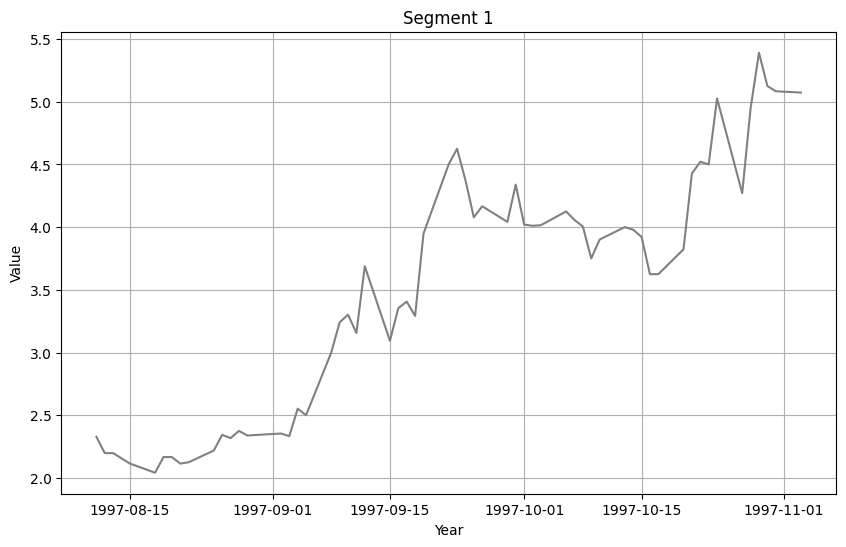

In [9]:
plot_timeseries_sequence(segment_1["Close"], "Segment 1", "Year", "Value", 'gray')

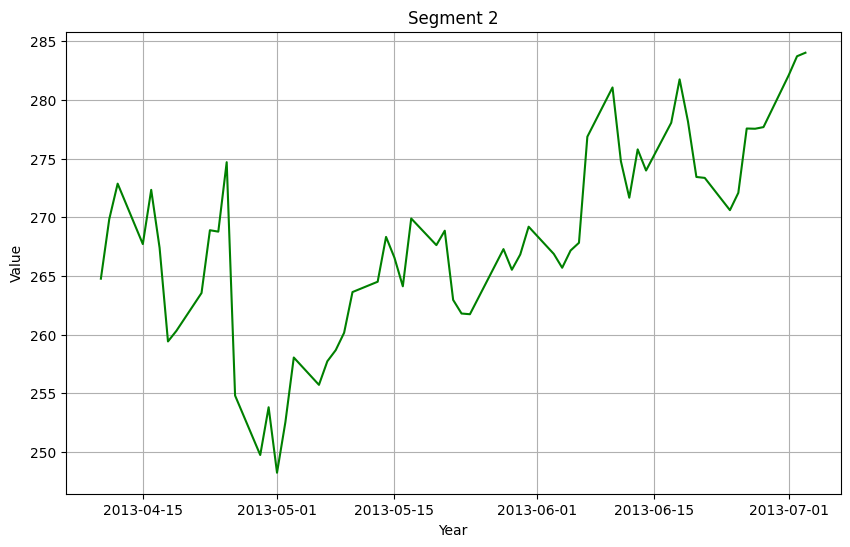

In [10]:
plot_timeseries_sequence(segment_2["Close"], "Segment 2", "Year", "Value", 'green')

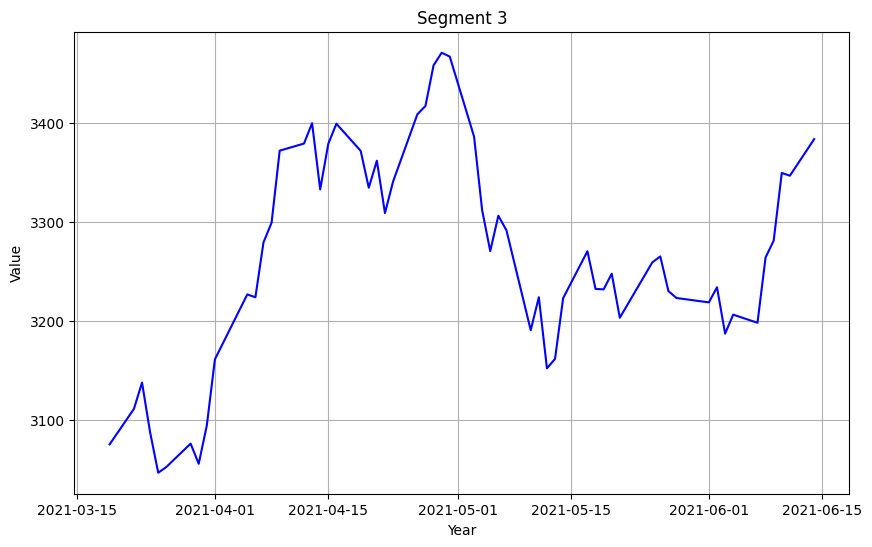

In [11]:
plot_timeseries_sequence(segment_3["Close"], "Segment 3", "Year", "Value", 'blue')

Let's turn the timeseries into networks (graphs)!

In [12]:
def sequence_to_graph(time_series, Q, phi, color):
    strategy = TimeseriesToQuantileGraph (Q, phi)
    g = strategy.to_graph(time_series, phi)
    pos= nx.circular_layout(g, scale=1)
    plt.figure(1,figsize=(8,8))
    
    
    all_weights = []
    for (q1, q2, data) in g.edges(data=True):
        all_weights.append(data['weight'])
    unique_weights = list(set(all_weights))
    
    nx.draw_networkx_nodes(g, pos, g.nodes, node_size=300, node_color = color)
    
    labels = {node: node for node in g.nodes()}
    nx.draw_networkx_labels(g, pos, labels, font_size=12, font_color='black')
    
    for weight in unique_weights:
        weighted_edges = [(q1, q2) for (q1, q2, edge_attr) in g.edges(data=True) if edge_attr['weight']==weight]
        width = weight*len(g.nodes)*5.0/sum(all_weights)
        nx.draw_networkx_edges(g,pos,edgelist=weighted_edges,width=width,edge_color='black',node_size=300)
        
    plt.show()

In [13]:
 def ts2q(time_series, Q):
        quantiles = np.linspace(0, 1, Q + 1)
        quantile_bins = np.quantile(time_series, quantiles)
        quantile_bins[0] -= 1e-9
        quantile_indices = np.digitize(time_series, quantile_bins, right=True) - 1
        return quantile_bins, quantile_indices

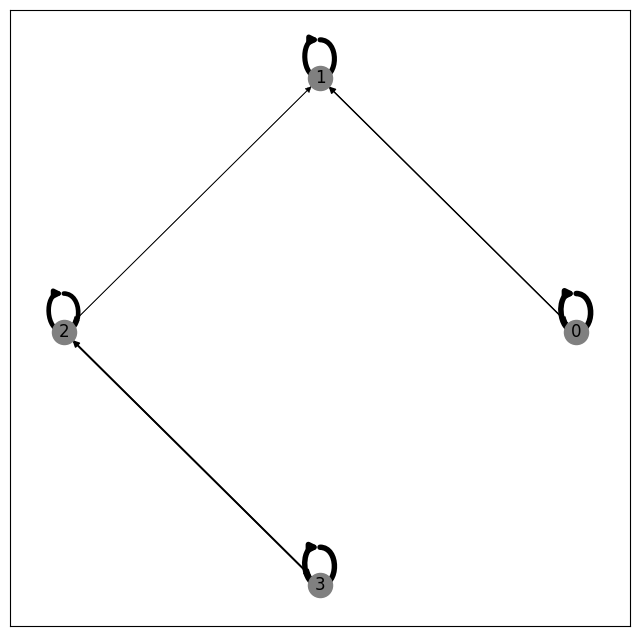

(array([2.041667  , 2.35156275, 3.71875   , 4.13541675, 5.390625  ]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [14]:
sequence_to_graph(segment_1["Close"],4,1, 'gray')
ts2q(segment_1["Close"],4)

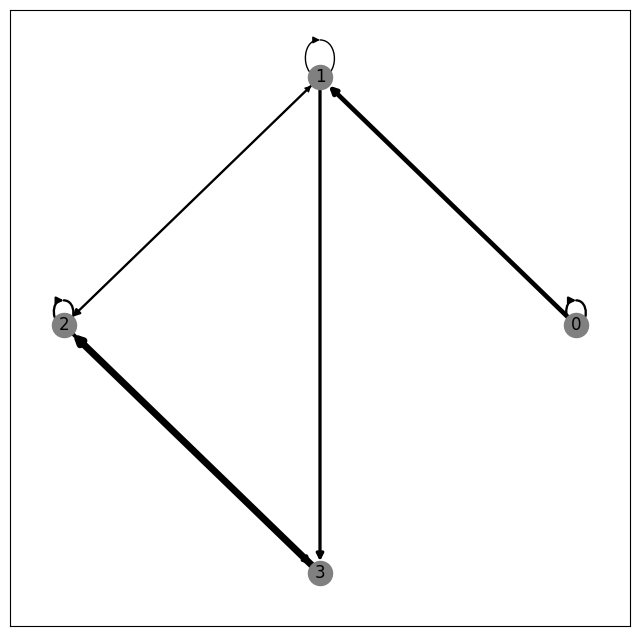

In [15]:
sequence_to_graph(segment_1["Close"], 4, 10, 'gray')

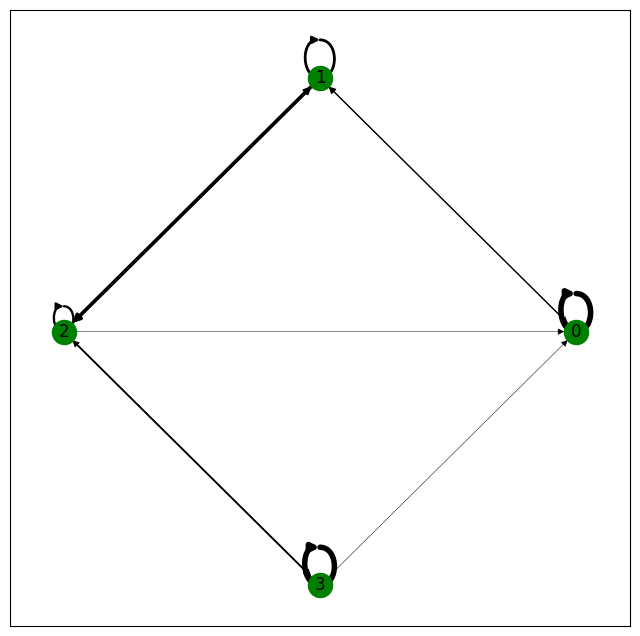

In [16]:
sequence_to_graph(segment_2["Close"],4,1, 'green')

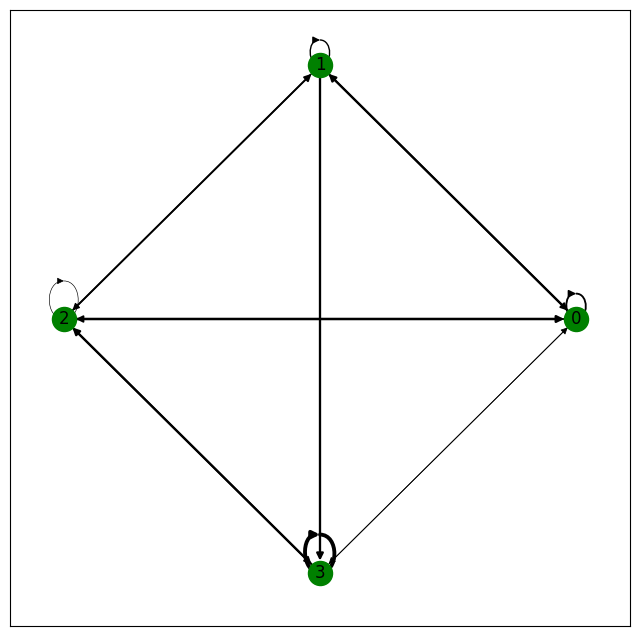

In [17]:
sequence_to_graph(segment_2["Close"],4,10, 'green')

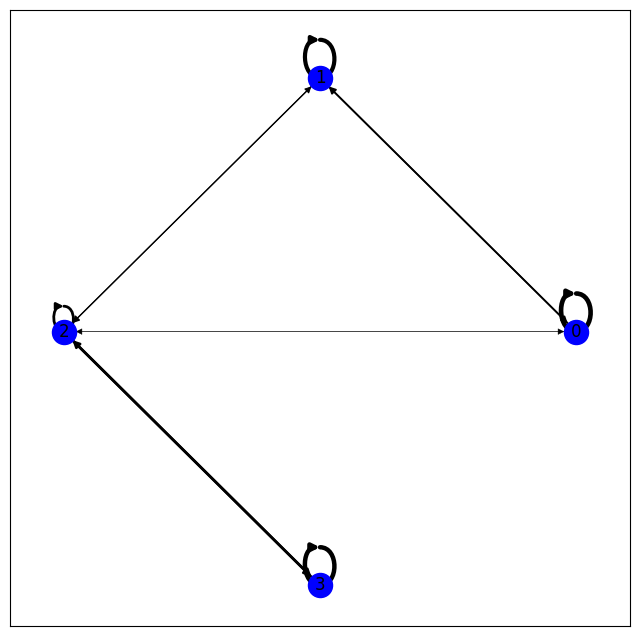

In [18]:
sequence_to_graph(segment_3["Close"],4,1, 'blue')

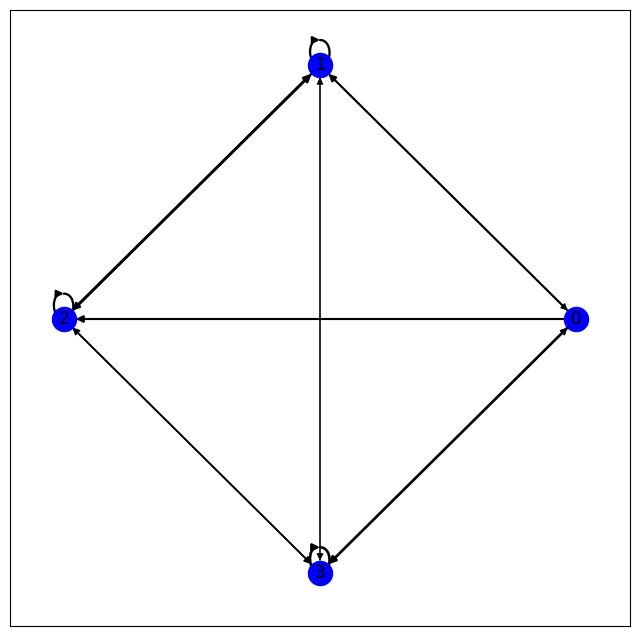

In [19]:
sequence_to_graph(segment_3["Close"], 4, 10, 'blue')

In [20]:
x = list(range(1,21))
y = [0.35, 0.9, 0.3, 0.8, 0.6, 0.95, 0.1, 0.4, 0.9, 0.15, 0.5, 5, 0.05, 0.1, 0.2, 0.7, 0.6, 0.9, 0.3, 0.4]

df = pd.DataFrame({'x': x, 'y': y})
df.set_index("x", inplace=True)

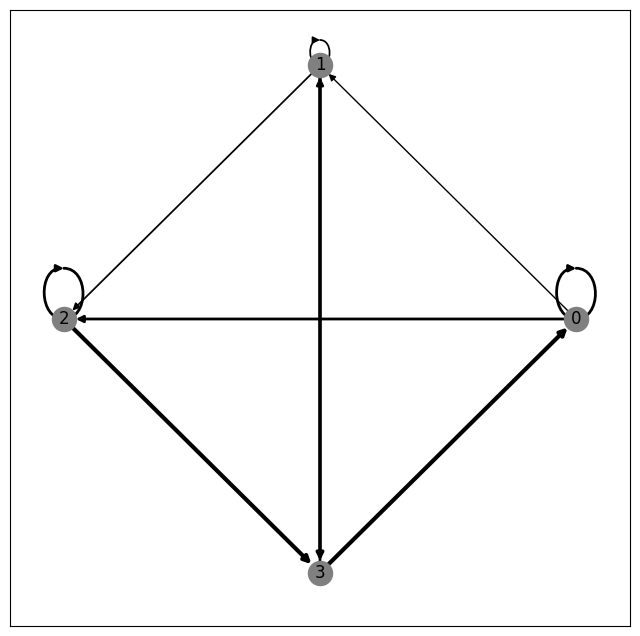

In [21]:
sequence_to_graph(df["y"],4, 1, 'gray')

In [22]:
import numpy as np
y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# y = [0.35, 0.9, 0.3, 0.8, 0.6, 0.95, 0.1, 0.4, 0.9, 0.15, 0.5, 5, 0.05, 0.1, 0.2, 0.7, 0.6, 0.9, 0.3, 0.4]

# Define quantiles (0%, 25%, 50%, 75%, 100%)
quantiles = np.linspace(0, 1, 5)

# Compute quantile bins
quantile_bins = np.quantile(y, quantiles)

# Adjust bins to ensure all values fall within the bins
quantile_bins[0] -= 1e-9  # Slightly reduce the first bin edge to include the minimum value

# Digitize the data
quantile_indices = np.digitize(y, quantile_bins, right=True) - 1

print("Quantile Bins:", quantile_bins)
print("Quantile Indices:", quantile_indices)

Quantile Bins: [ 1.    3.25  5.5   7.75 10.  ]
Quantile Indices: [0 0 0 1 1 2 2 3 3 3]
